In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/Datasets/Dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [ ]:
import os

PATH = 'Dataset'

classes = os.listdir(PATH)
classes

['Car', 'Truck', 'Bus', 'motorcycle']

In [ ]:
imgs, labels = [], []

for i, lab in enumerate(classes):
  paths = os.listdir(f'{PATH}/{lab}')
  print(f'Categoría: {lab}. Imágenes: {len(paths)}')
  paths = [p for p in paths if p[-3:] == "jpg"]
  imgs += [f'{PATH}/{lab}/{img}' for img in paths]
  labels += [i]*len(paths)

Categoría: Car. Imágenes: 100
Categoría: Truck. Imágenes: 100
Categoría: Bus. Imágenes: 100
Categoría: motorcycle. Imágenes: 100


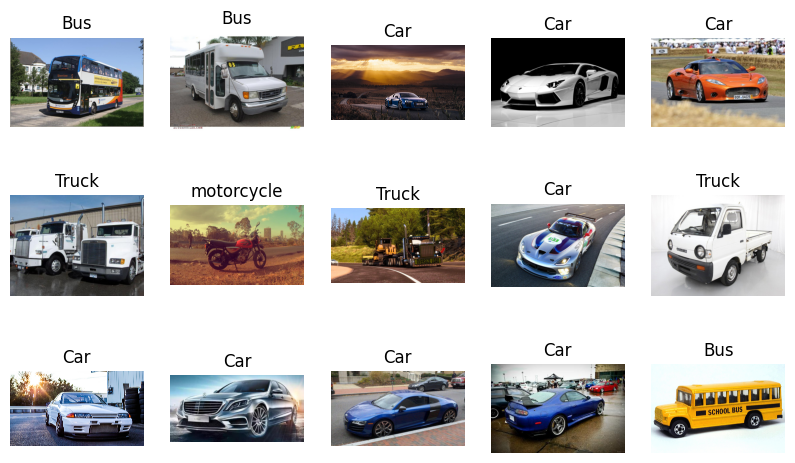

In [ ]:
import random
from skimage import io
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(imgs)-1)
    img = io.imread(imgs[ix])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(classes[labels[ix]])
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_labels, test_labels = train_test_split(imgs, labels, test_size=0.2, stratify=labels)

len(train_imgs), len(test_imgs)

(320, 80)

In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, trans, device):
    self.X = X
    self.y = y
    self.trans = trans
    self.device = device

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    # cargar la imágen
    img = io.imread(self.X[ix])
    # aplicar transformaciones
    #print(f"imagen: {img}")
    if self.trans:
      img = self.trans(image=img)["image"]
    return torch.from_numpy(img / 255.).float().permute(2,0,1), torch.tensor(self.y[ix])

In [ ]:
import albumentations as A

trans = A.Compose([
    A.Resize(64, 64)
])

dataset = {
    'train': Dataset(train_imgs, train_labels, trans, device),
    'test': Dataset(test_imgs, test_labels, trans, device)
}

len(dataset['train']), len(dataset['test'])

(320, 80)

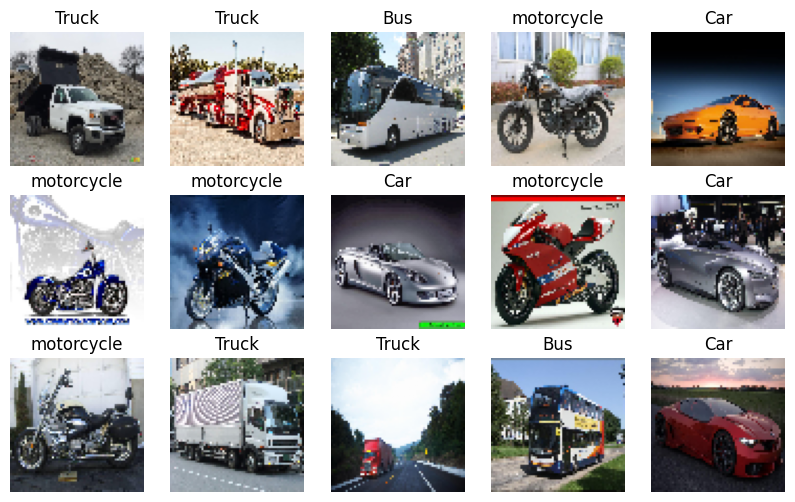

In [ ]:
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset['train'])-1)
    img, lab = dataset['train'][ix]
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(classes[lab])
plt.show()

In [ ]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=64, shuffle=False, pin_memory=True)
}

imgs, labels = next(iter(dataloader['train']))
imgs.shape

torch.Size([64, 3, 64, 64])

In [ ]:
def block(c_in, c_out, k=5, p=2, s=2, pk=2, ps=1):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s), # p=2, s=2
        torch.nn.ReLU(), # recomendable para las capas internas
        torch.nn.MaxPool2d(pk, stride=ps)# pk=2 , ps=1
    )

class CNN(torch.nn.Module):
  def __init__(self, n_channels=3, n_outputs=4):
    super().__init__()

    # jugar con estos datos
    self.conv1 = block(n_channels, 512)
    self.conv2 = block(512, 256)
    self.conv3 = block(256, 128)
    self.conv4 = block(128, 64)
    self.fc = torch.nn.Linear(64 * 3 * 3, n_outputs)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = x.view(x.shape[0], -1) # aplananamiento
    x = self.fc(x) # fully conect
    return x

In [ ]:
'''def block(c_in, c_out, k=5, p=2, s=2, pk=2, ps=1):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s), # p=2, s=2
        torch.nn.ReLU(), # recomendable para las capas internas
        torch.nn.MaxPool2d(pk, stride=ps)# pk=2 , ps=1
    )

class CNN(torch.nn.Module):
    def __init__(self, n_channels=3, n_outputs=4):
        super().__init__()

        # Configuración de las capas convolucionales
        self.conv1 = block(n_channels, 64)
        self.conv2 = block(64, 128)
        self.conv3 = block(128, 256)
        self.conv4 = block(256, 512)
        self.conv5 = block(512, 1024)

        # Capa completamente conectada
        self.fc = torch.nn.Linear(1024, n_outputs)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(x.shape[0], -1) # Aplanamiento
        x = self.fc(x) # Totalmente conectado
        return x
        '''

'def block(c_in, c_out, k=5, p=2, s=2, pk=2, ps=1):\n    return torch.nn.Sequential(\n        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s), # p=2, s=2\n        torch.nn.ReLU(), # recomendable para las capas internas\n        torch.nn.MaxPool2d(pk, stride=ps)# pk=2 , ps=1\n    )\n\nclass CNN(torch.nn.Module):\n    def __init__(self, n_channels=3, n_outputs=4):\n        super().__init__()\n\n        # Configuración de las capas convolucionales\n        self.conv1 = block(n_channels, 64)\n        self.conv2 = block(64, 128)\n        self.conv3 = block(128, 256)\n        self.conv4 = block(256, 512)\n        self.conv5 = block(512, 1024)\n        \n        # Capa completamente conectada\n        self.fc = torch.nn.Linear(1024, n_outputs)\n\n    def forward(self, x):\n        x = self.conv1(x)\n        x = self.conv2(x)\n        x = self.conv3(x)\n        x = self.conv4(x)\n        x = self.conv5(x)\n        x = x.view(x.shape[0], -1) # Aplanamiento\n        x = self.fc(x) # Totalme

In [ ]:
model = CNN()

output = model(torch.randn(64, 3, 64, 64))

In [ ]:
from tqdm import tqdm
import numpy as np

# jugar con estos parametros
epoch = 15
tazaAprendizaje=1e-3

#  Toma como entrada el modelo de red neuronal (model), el dataloader que contiene los datos de entrenamiento
#y prueba (dataloader), y el número de épocas de entrenamiento (epochs).
def fit(model, dataloader, epochs= epoch):
    model.to(device) # Mueve el modelo a la GPU

    optimizer = torch.optim.Adam(model.parameters(), lr = tazaAprendizaje) # Crea un optimizador Adam para optimizar los parámetros del modelo
    criterion = torch.nn.CrossEntropyLoss() # Define una función de pérdida de entropía cruzada:
    #que se utilizará para calcular la pérdida durante el entrenamiento.

    for epoch in range(1, epochs+1): # Comienza un bucle de entrenamiento a lo largo de las épocas especificadas
        model.train()
        train_loss, train_acc = [], [] # listas
        bar = tqdm(dataloader['train'])
        for batch in bar:
          # Se obtienen los datos de entrada (X) y las etiquetas (y) del lote.
            X, y = batch
            X, y = X.to(device), y.to(device) # se mueve a la GPU

            optimizer.zero_grad() # Se inicializa el gradiente del optimizador

            #prediccion
            y_hat = model(X) # Se pasa la entrada a través del modelo para obtener las predicciones (y_hat).

            loss = criterion(y_hat, y) # Se calcula la pérdida entre las predicciones y las etiquetas verdaderas utilizando la función de pérdida de entropía cruzada.
            loss.backward() # retropropagación del gradiente
            optimizer.step() # Se actualizan los parámetros del modelo

# Se registran la pérdida y la precisión del entrenamiento en listas separadas.
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)

            # Se muestra el progreso del entrenamiento en la barra de progreso.
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []

        model.eval() #  se establece el modelo en modo de evaluación
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y) # Se calcula la pérdida y la precisión

# Se registran la pérdida y la precisión del entrenamiento en listas separadas.
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.2f} val_acc {np.mean(val_acc):.2f}")

      # pérdida promedio y la precisión promedio en el conjunto de entrenamiento y prueba para cada época
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.2f} val_loss {np.mean(val_loss):.2f} acc {np.mean(train_acc):.2f} val_acc {np.mean(val_acc):.2f}")

In [ ]:
model = CNN()
fit(model, dataloader)

val_loss 1.40 val_acc 0.27: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


Epoch 1/15 loss 1.76 val_loss 1.40 acc 0.24 val_acc 0.27


val_loss 1.39 val_acc 0.27: 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]


Epoch 2/15 loss 1.41 val_loss 1.39 acc 0.23 val_acc 0.27


val_loss 1.39 val_acc 0.27: 100%|██████████| 2/2 [00:01<00:00,  1.68it/s]


Epoch 3/15 loss 1.39 val_loss 1.39 acc 0.27 val_acc 0.27


val_loss 1.37 val_acc 0.38: 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]


Epoch 4/15 loss 1.38 val_loss 1.37 acc 0.27 val_acc 0.38


val_loss 1.35 val_acc 0.37: 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]


Epoch 5/15 loss 1.36 val_loss 1.35 acc 0.31 val_acc 0.37


val_loss 1.34 val_acc 0.46: 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]


Epoch 6/15 loss 1.33 val_loss 1.34 acc 0.33 val_acc 0.46


val_loss 1.29 val_acc 0.48: 100%|██████████| 2/2 [00:00<00:00,  2.21it/s]


Epoch 7/15 loss 1.30 val_loss 1.29 acc 0.41 val_acc 0.48


val_loss 1.25 val_acc 0.43: 100%|██████████| 2/2 [00:00<00:00,  2.21it/s]


Epoch 8/15 loss 1.25 val_loss 1.25 acc 0.42 val_acc 0.43


val_loss 1.13 val_acc 0.60: 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]


Epoch 9/15 loss 1.17 val_loss 1.13 acc 0.48 val_acc 0.60


val_loss 1.11 val_acc 0.50: 100%|██████████| 2/2 [00:01<00:00,  1.72it/s]


Epoch 10/15 loss 1.02 val_loss 1.11 acc 0.55 val_acc 0.50


val_loss 1.22 val_acc 0.48: 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]


Epoch 11/15 loss 1.02 val_loss 1.22 acc 0.55 val_acc 0.48


val_loss 1.26 val_acc 0.48: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Epoch 12/15 loss 0.99 val_loss 1.26 acc 0.57 val_acc 0.48


val_loss 1.19 val_acc 0.54: 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]


Epoch 13/15 loss 0.91 val_loss 1.19 acc 0.63 val_acc 0.54


val_loss 1.06 val_acc 0.66: 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


Epoch 14/15 loss 0.83 val_loss 1.06 acc 0.69 val_acc 0.66


val_loss 0.95 val_acc 0.67: 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]

Epoch 15/15 loss 0.66 val_loss 0.95 acc 0.74 val_acc 0.67


In [ ]:
import matplotlib.pyplot as plt

def plot_predictions(model, dataloader, r, c):
    model.to('cuda')
    with torch.no_grad():
        for loader_name, test_loader in dataloader.items():
            if loader_name == 'train':
                continue
            # Mostrar las primeras imágenes del primer lote del DataLoader de prueba
            fig = plt.figure(figsize=(2*c, 2*r))
            for batch_idx, (data, target) in enumerate(test_loader):
                if batch_idx == 0:
                    data = data.to('cuda')
                    target = target.to('cuda')
                    output = model(data)
                    predictions = output.argmax(dim=1)
                    for i in range(r * c):
                        plt.subplot(r, c, i + 1)
                        img = data[i].cpu().numpy().transpose(1, 2, 0)
                        y_true = target[i].item()
                        y_pred = predictions[i].item()
                        plt.imshow(img, cmap='gray')
                        plt.axis("off")
                        #plt.title(f"{y_true}/{y_pred}", color="green" if y_true == y_pred else "red")
                        plt.title(f"{classes[y_true]}/{classes[y_pred]}", color="green" if y_true == y_pred else "red")
                        plt.tight_layout()
                    plt.show()
                    break

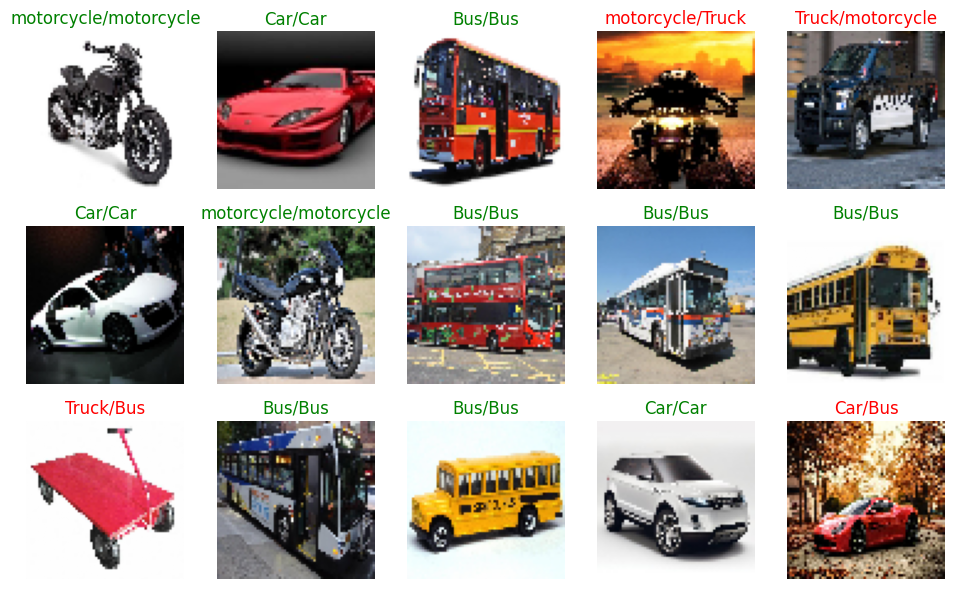

In [ ]:
plot_predictions(model, dataloader, 3, 5)
# Esto mostrará las primeras imágenes del primer lote del DataLoader de prueba:
#3 filas y 5 columnas de subgráficos.